In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Data cleaning and processing

In [2]:
# Load all CSV files
network_manager = pd.read_csv('Data/Bornholm Network Manager.csv', delimiter=';')
nordpool_price = pd.read_csv('Data/NordPool.csv', delimiter=';')
norwegian_weather = pd.read_csv('Data/Norwegian.csv', delimiter=';')
weather_observation = pd.read_csv('Data/Weather Observation.csv', delimiter=';')
energinet_price = pd.read_csv('Data/Energinet Balance price.csv', delimiter=';')

# Filter the Energinet data to only include zone DK2
filtered_energinet_price = energinet_price[energinet_price['PriceArea | PriceArea | 804696'] == 'DK2']
energinet_price = filtered_energinet_price

# Convert the 'ts' column to datetime format for each dataset
network_manager['ts'] = pd.to_datetime(network_manager['ts'], dayfirst=True)
nordpool_price['ts'] = pd.to_datetime(nordpool_price['ts'], dayfirst=True)
norwegian_weather['ts'] = pd.to_datetime(norwegian_weather['ts'], dayfirst=True)
weather_observation['ts'] = pd.to_datetime(weather_observation['ts'], dayfirst=True)
energinet_price['ts'] = pd.to_datetime(energinet_price['ts'], dayfirst=True)

# Set 'ts' as the index for each DataFrame
network_manager.set_index('ts', inplace=True)
nordpool_price.set_index('ts', inplace=True)
norwegian_weather.set_index('ts', inplace=True)
weather_observation.set_index('ts', inplace=True)
energinet_price.set_index('ts', inplace=True)

# Resample network_manager data to hourly intervals (average the data)
network_manager_hourly = network_manager.resample('H').mean()

# Reset the index to bring 'ts' back as a regular column for merging
network_manager_hourly.reset_index(inplace=True)

/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_39977/950961637.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network_manager_hourly = network_manager.resample('H').mean()


In [3]:
# Check the columns in each DataFrame
print(network_manager.columns)
# print(energinet_price.columns)
# print(nordpool_price.columns)
# print(norwegian_weather.columns)
# print(weather_observation.columns)

print(energinet_price.index)


Index(['Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133',
       'Hasle Vind Active Power | has_vin_effekt | 804123',
       'Hasle Vind Current | has_vin_belastning | 804117'],
      dtype='object')
DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-01-31 14:00:00', '2023-01-31 15:00:00',
               '2023-01-31 16:00:00', '2023-01-31 17:00:00',
               '2023-01-31 18:00:00', '2023-01-31 19:00:00',
               '2023-01-31 20:00:00', '2023-01-31 21:00:00',
               '2023-01-31 22:00:00', '2023-01-31 23:00:00'],
              dtype='datetime64[ns]', name='ts', length=744, freq=None)


In [4]:
# Merge the datasets on the 'ts' index
merged_data = network_manager_hourly.merge(nordpool_price, on='ts', how='inner')
merged_data = merged_data.merge(norwegian_weather, on='ts', how='inner')
merged_data = merged_data.merge(weather_observation, on='ts', how='inner')
merged_data = merged_data.merge(energinet_price, on='ts', how='inner')

# Handle missing data by forward filling
merged_data.fillna(method='ffill', inplace=True)

# Sort the data by the timestamp column 'ts' to ensure time order
merged_data.sort_values(by='ts', inplace=True)

# Define the feature columns (X) and the target column (y)
# For example, if 'Hasle Vind Active Power' is the target column
X = merged_data.drop(columns=['Hasle Vind Active Power | has_vin_effekt | 804123',
                              'HourDK | HourDK | 804695',
                              'HourUTC | HourUTC | 804694'])

y = merged_data['Hasle Vind Active Power | has_vin_effekt | 804123']

# Check the resulting merged data and features
print(merged_data.head())


                   ts  \
0 2023-01-02 00:00:00   
1 2023-01-02 01:00:00   
2 2023-01-02 02:00:00   
3 2023-01-02 03:00:00   
4 2023-01-02 04:00:00   

   Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133  \
0                                          10.402319                    
1                                          10.479418                    
2                                          10.473787                    
3                                          10.477362                    
4                                          10.401084                    

   Hasle Vind Active Power | has_vin_effekt | 804123  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   Hasle Vind Current | has_vin_belastning | 804117  \
0                 

/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_39977/2882756237.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [5]:
print(X.columns)


Index(['ts',
       'Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133',
       'Hasle Vind Current | has_vin_belastning | 804117',
       'Nordpool Elspot Prices - hourly price DK-DK2 EUR/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_eur | 3038',
       'Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820',
       'Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270',
       'Weather forecast for wind speed at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_speed | 128286',
       'Weather forecast for wind speed y_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/y_wind_10m | 128318',
       'Weather forecast for wind speed x_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/x_wind_10m | 128302',
       'Weather forecast for wind direction at Nordhavn | 9F7J/PJ/84/MET-Norway/forecast/wind_direction | 797979',
       'Weather forecast for wind speed at Nordhavn 

## Step 3

In [6]:
# Assuming your data has a 'ts' column (time series or timestamp)
ts_column = X['ts']  # Extract the 'ts' column
price_Area = X['PriceArea | PriceArea | 804696']
X_features = X.drop(columns=['ts','PriceArea | PriceArea | 804696'])  # Remove 'ts' from features

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Split the data into training and testing sets (80% training, 20% testing)
# Perform a time series split: 80% for training, 20% for testing
split_index = int(0.8 * len(merged_data))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


X_train_df = pd.DataFrame(X_train, index=ts_column.index[:len(X_train)])
X_test_df = pd.DataFrame(X_test, index=ts_column.index[len(X_train):])

# Concatenate the 'ts' column to X_train and X_test
X_train = pd.concat([X_train_df, ts_column[:len(X_train)]], axis=1)
X_test = pd.concat([X_test_df, ts_column[len(X_train):]], axis=1)

# Print shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (565, 30)
Testing data shape: (142, 30)


In [7]:
# # Search for the columns where '57,91' appears
# mask = merged_data.apply(lambda x: x.astype(str).str.contains('57,91'))

# # Find the columns that contain the value '57,91'
# problematic_columns = mask.any(axis=0)
# columns_with_issues = merged_data.columns[problematic_columns]

# # Print the column names
# print("Columns containing '57,91':")
# print(columns_with_issues)

In [7]:
# Step 3.1: Implementing Linear Regression with Gradient Descent in matrix form
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # Parameter vector (weights and bias)
        self.cost_history = []  # To store cost function values over iterations
    
    def fit(self, X, y):
        # Ensure that X and y are NumPy arrays and convert them to float type
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        # Number of training samples (m) and number of features (n)
        m, n = X.shape

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((m, 1)), X]  # X_b is now (m, n+1) with the bias term
        
        # Initialize theta (parameters) with zeros
        self.theta = np.zeros(n + 1)  # Including bias
        
        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_b.dot(self.theta)
            
            # Compute cost (MSE)
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)  # Store cost for plotting

            # Gradient (in matrix form)
            gradient = (1 / m) * X_b.T.dot(y_pred - y)
            
            # Update the parameters theta
            self.theta -= self.learning_rate * gradient
    
    def predict(self, X):
        # Ensure that X is a NumPy array and convert it to float type
        X = np.array(X, dtype=float)
        
        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Return predictions (y_pred = X_b * theta)
        return X_b.dot(self.theta)

# Step 3.1: Implementing the closed-form solution (Normal Equation)
def closed_form_solution(X, y):
    # Ensure that X and y are NumPy arrays and convert them to float type
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    
    # Add a bias (intercept) column of ones to the input matrix X
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Normal equation: theta = (X.T * X)^(-1) * X.T * y
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best


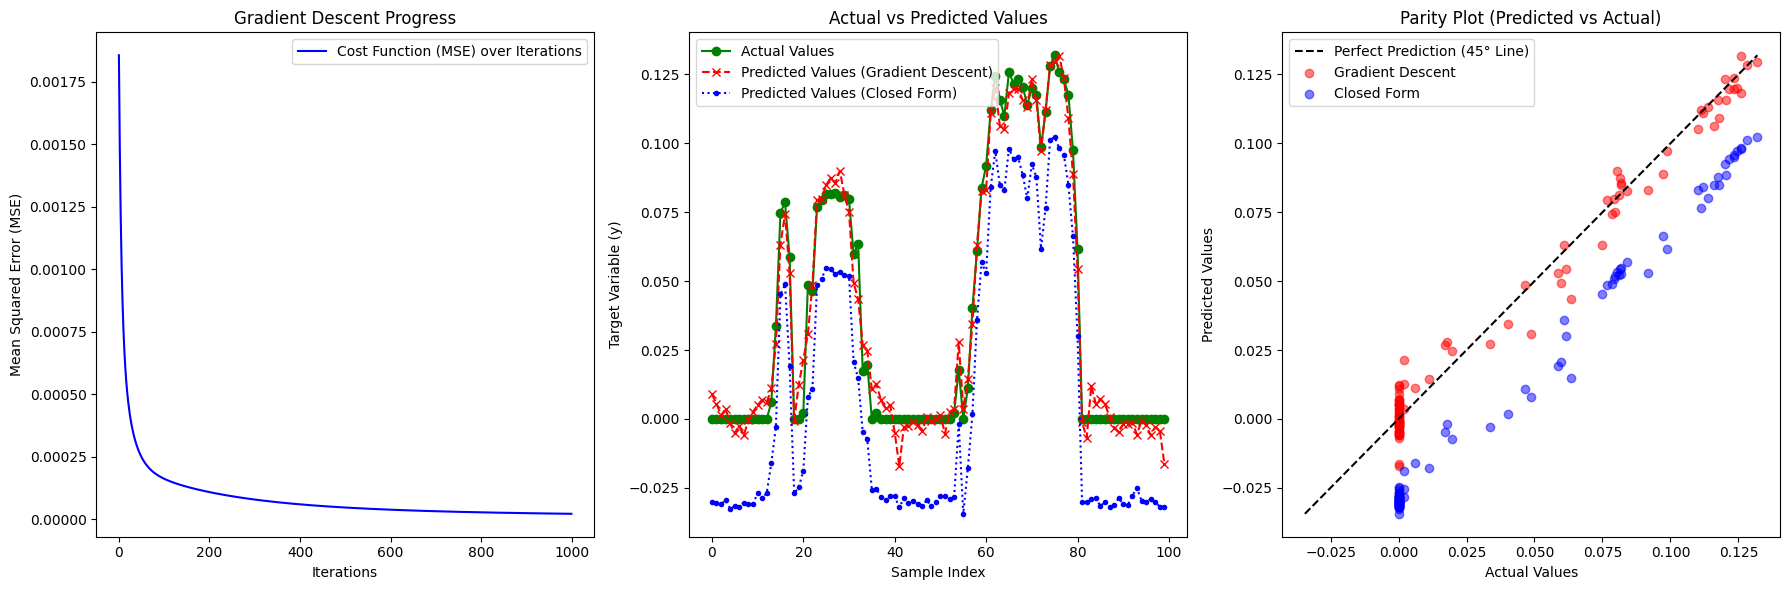

Gradient Descent Coefficients: [ 2.52207872e-02 -2.46267993e-05  3.55561121e-02 -3.57045943e-03
 -3.57587368e-03 -8.72326516e-04  5.10659983e-03  1.02895173e-03
  1.16406762e-02 -2.37083558e-04 -9.40508169e-04  1.53054960e-03
 -3.28097961e-03 -8.67981833e-04 -2.54180100e-03  4.09949215e-03
 -8.27604548e-04 -4.38509414e-03 -1.09127634e-03 -2.11224836e-03
 -2.00696018e-03 -9.96606460e-03  7.19648889e-04  2.02535069e-03
  2.02033917e-03  5.57362677e-04  5.52812224e-04 -1.11624887e-03
 -1.12139125e-03 -2.41239903e-03]
Closed-Form Solution Coefficients: [ 1.43500827e+06  3.33135791e-04  4.79366900e-02 -3.08261037e+01
  3.08331120e+01 -1.29195825e-04 -4.02682040e-03  4.30463499e-03
  9.70349951e-03 -1.45964404e-03  1.27365301e-03 -5.13998967e-04
 -3.02381136e-03  4.78880172e-03  4.15166390e-03 -4.18023197e-03
 -4.59978426e-03  2.74238870e-04 -2.39055671e-03  1.29660848e-03
  1.80332616e+07 -2.45987986e-03 -8.15832257e-04 -8.07921305e+00
  8.08268492e+00  1.03253397e+01 -1.03285978e+01  3.233

In [10]:
# Step 3.1: Test on a small sample (e.g., first 100 rows)
X_train_small = np.array(X_train_df[:100], dtype=float)  # Ensure proper conversion
y_train_small = np.array(y_train[:100], dtype=float)  # Ensure proper conversion

# Train using Gradient Descent
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
gd_model.fit(X_train_small, y_train_small)
y_pred_gd = gd_model.predict(X_train_small)

# Train using Closed-Form Solution (Normal Equation)
theta_best = closed_form_solution(X_train_small, y_train_small)
X_b_small = np.c_[np.ones((X_train_small.shape[0], 1)), X_train_small]
y_pred_closed_form = X_b_small.dot(theta_best)

# Create a figure with three subplots: Gradient Descent progress, Actual vs. Predicted, Parity plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train_small, label='Actual Values', marker='o', color='g')
axs[1].plot(y_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train_small.min(), y_pred_gd.min(), y_pred_closed_form.min())
max_val = max(y_train_small.max(), y_pred_gd.max(), y_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train_small, y_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train_small, y_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Verify that both solutions are close by comparing the predictions
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best)
print("Are the predictions close? ", np.allclose(y_pred_gd, y_pred_closed_form))


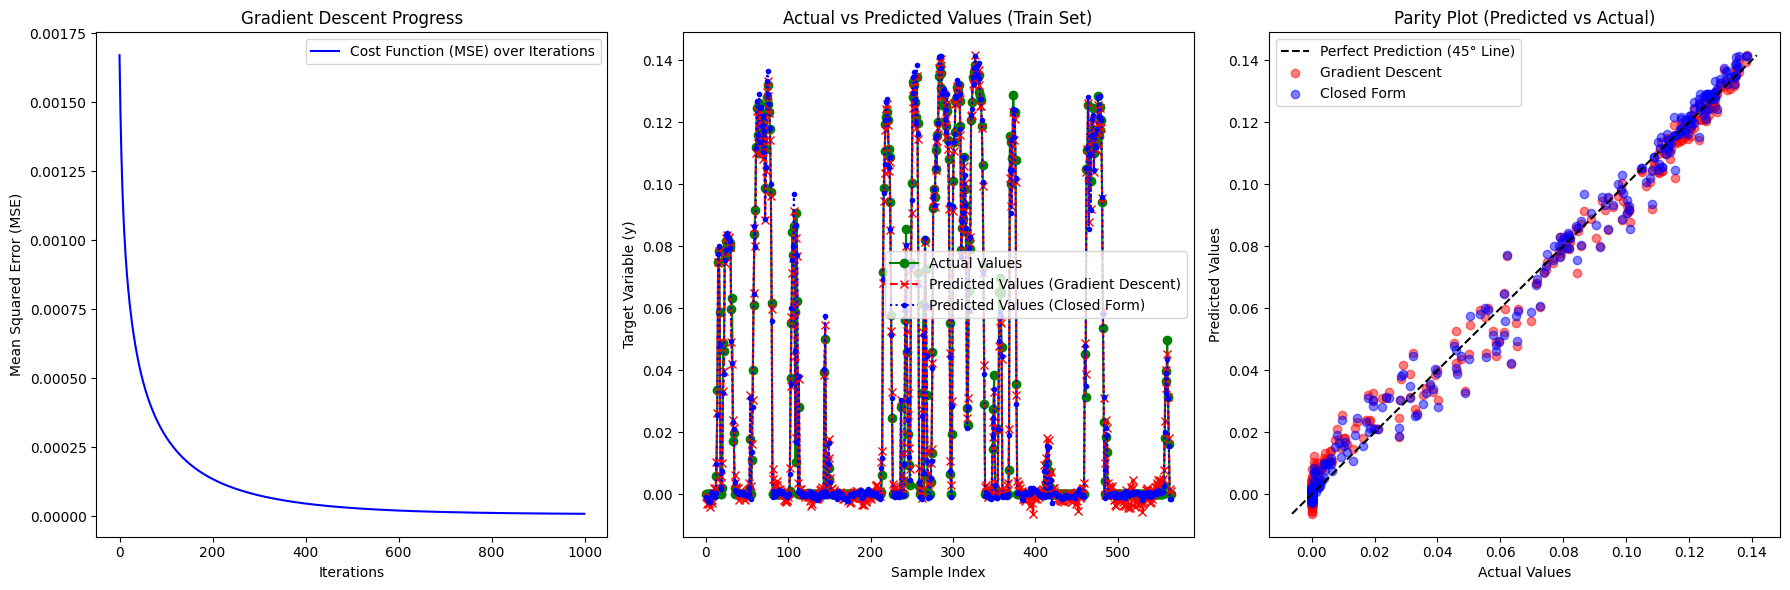

Gradient Descent Coefficients: [ 3.72158524e-02 -2.68431556e-04  4.75522235e-02 -3.72447152e-04
 -3.67583796e-04 -1.00927846e-03  2.26603228e-03  4.75918259e-04
 -5.98770174e-05 -1.08931691e-03 -9.38714622e-04  6.24418715e-04
 -3.86234784e-04  8.70415716e-04 -3.57596060e-04 -3.62419452e-04
  1.02758948e-03  1.13208710e-03  3.49194953e-04  5.02334151e-04
  1.55843074e-04  4.31317869e-04  7.31971331e-06  6.76295488e-04
  6.77928628e-04 -2.90938581e-04 -2.88063453e-04  1.01699682e-04
  1.04501264e-04 -9.78449868e-04]
Closed-Form Solution Coefficients: [ 3.74541342e-02 -1.11728415e-04  5.13944484e-02  3.81382446e-01
 -3.80250140e-01  6.78177969e-05 -2.26463476e-04  6.76487948e-04
  2.84367578e-04  2.37552324e-04 -3.58340711e-04  1.48565137e-04
 -8.05726640e-04  1.11032023e-03  5.15484272e-04 -1.19159504e-03
 -3.45227243e-04  1.49353628e-04 -3.98034607e-04  1.55189767e-04
  2.03036699e-04 -1.40459045e-04 -3.37601500e-04  3.55038050e+00
 -3.54870951e+00 -1.00755458e+00  1.00597033e+00 -6.166

In [11]:
# Assuming X_train_df and y_train are defined and scaled already

# Closed-Form Solution (Normal Equation)
theta_best_full = closed_form_solution(X_train_df, y_train)
X_b_full = np.c_[np.ones((X_train_df.shape[0], 1)), X_train_df]
y_train_pred_closed_form = X_b_full.dot(theta_best_full)

# Train using Gradient Descent on full dataset
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)  # You can increase iterations if needed
gd_model.fit(X_train_df, y_train)
y_train_pred_gd = gd_model.predict(X_train_df)

# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[1].plot(y_train_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_train_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values (Train Set)')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_closed_form.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train, y_train_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train, y_train_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Output the coefficients for both methods
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best_full)

# Compare the predictions and check if they are close
print("Are the predictions close? ", np.allclose(y_train_pred_gd, y_train_pred_closed_form))


In [12]:
# Step 3.3: Evaluate the model on the testing dataset
X_b_test = np.c_[np.ones((X_test.shape[0], 1)), X_test_df]
y_test_pred = X_b_test.dot(theta_best_full)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Root Mean Squared Error (RMSE): 0.003395813855192423
Mean Absolute Error (MAE): 0.0024550830651476397
R-squared (R²): 0.9965042250347738


## Step 4

In [15]:
# Step 4.1: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)

# Train the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_train_pred_poly = model_poly.predict(X_train_poly)

# Step 4.2: Define random weights and fit the weighted linear regression model
weights = np.random.rand(X_train_df.shape[0])  # Random weights for demonstration
model_weighted = LinearRegression()
model_weighted.fit(X_train_df, y_train, sample_weight=weights)
y_train_pred_weighted = model_weighted.predict(X_train_df)

# Evaluation metrics for all models
rmse_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_gd))
mae_linear = mean_absolute_error(y_train, y_train_pred_gd)
r2_linear = r2_score(y_train, y_train_pred_gd)

rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
r2_poly = r2_score(y_train, y_train_pred_poly)

rmse_weighted = np.sqrt(mean_squared_error(y_train, y_train_pred_weighted))
mae_weighted = mean_absolute_error(y_train, y_train_pred_weighted)
r2_weighted = r2_score(y_train, y_train_pred_weighted)

print(f"Linear Model RMSE: {rmse_linear}")
print(f"Polynomial Model RMSE: {rmse_poly}")
print(f"Weighted Model RMSE: {rmse_weighted}")


Linear Model RMSE: 0.004278705925041867
Polynomial Model RMSE: 0.0015919820729801753
Weighted Model RMSE: 0.003703287325677266


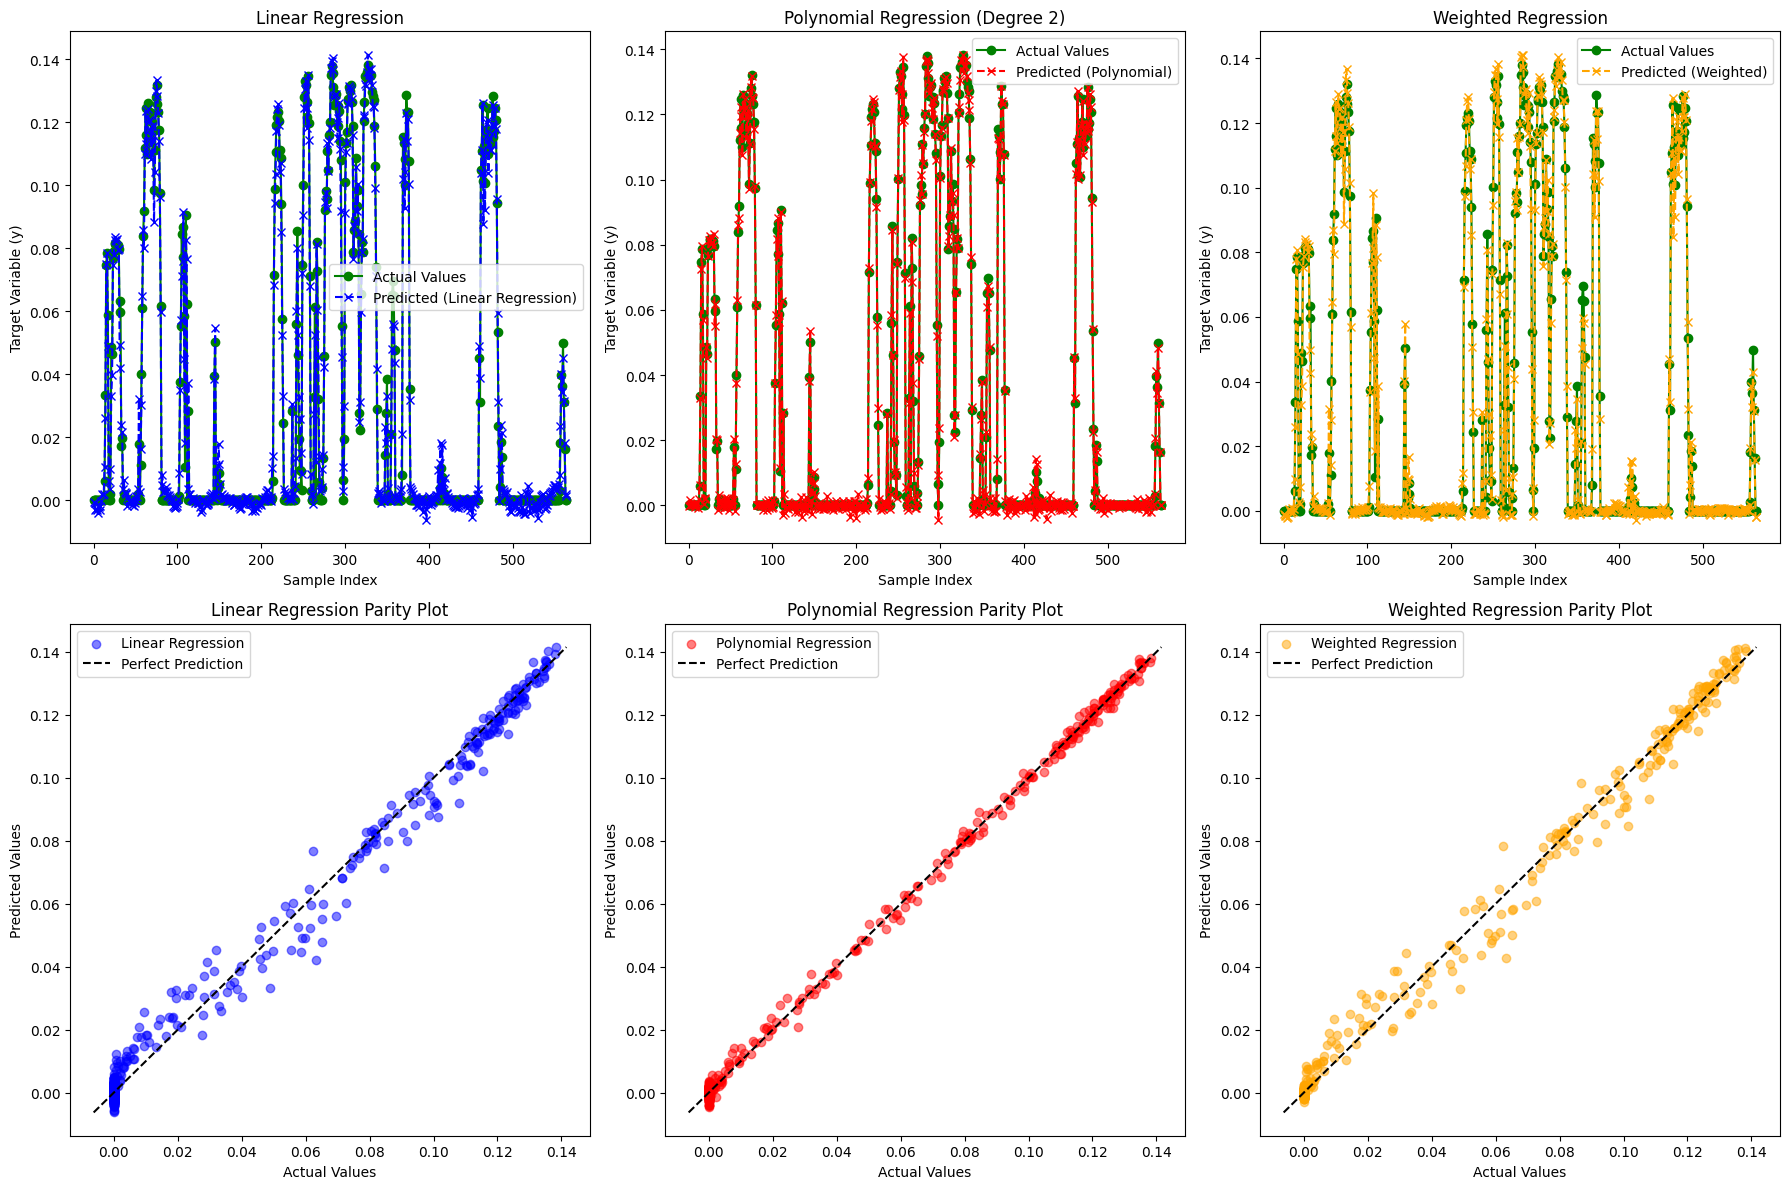

In [16]:
# Create a figure with six subplots (3x2): One row for actual vs. predicted, another for parity plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

### First row: Actual vs. Predicted values
# Subplot 1: Actual vs Predicted for Linear Regression (from Step 3)
axs[0, 0].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 0].plot(y_train_pred_gd, label='Predicted (Linear Regression)', marker='x', linestyle='--', color='b')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Target Variable (y)')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].legend()

# Subplot 2: Actual vs Predicted for Polynomial Regression (Step 4.1)
axs[0, 1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 1].plot(y_train_pred_poly, label='Predicted (Polynomial)', marker='x', linestyle='--', color='r')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Target Variable (y)')
axs[0, 1].set_title('Polynomial Regression (Degree 2)')
axs[0, 1].legend()

# Subplot 3: Actual vs Predicted for Weighted Regression (Step 4.2)
axs[0, 2].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 2].plot(y_train_pred_weighted, label='Predicted (Weighted)', marker='x', linestyle='--', color='orange')
axs[0, 2].set_xlabel('Sample Index')
axs[0, 2].set_ylabel('Target Variable (y)')
axs[0, 2].set_title('Weighted Regression')
axs[0, 2].legend()

### Second row: Parity plots (Predicted vs Actual, with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_poly.min(), y_train_pred_weighted.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_poly.max(), y_train_pred_weighted.max())

# Subplot 4: Parity plot for Linear Regression
axs[1, 0].scatter(y_train, y_train_pred_gd, color='b', alpha=0.5, label='Linear Regression')
axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Predicted Values')
axs[1, 0].set_title('Linear Regression Parity Plot')
axs[1, 0].legend()

# Subplot 5: Parity plot for Polynomial Regression
axs[1, 1].scatter(y_train, y_train_pred_poly, color='r', alpha=0.5, label='Polynomial Regression')
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title('Polynomial Regression Parity Plot')
axs[1, 1].legend()

# Subplot 6: Parity plot for Weighted Regression
axs[1, 2].scatter(y_train, y_train_pred_weighted, color='orange', alpha=0.5, label='Weighted Regression')
axs[1, 2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 2].set_xlabel('Actual Values')
axs[1, 2].set_ylabel('Predicted Values')
axs[1, 2].set_title('Weighted Regression Parity Plot')
axs[1, 2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
